## Store Sales - Time Series Forecasting

*In this project, we’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.* <br>

Specifically, we'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

#### 1.Data Exploration

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
df_store = pd.read_csv("stores.csv")
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [96]:
df_oil = pd.read_csv("oil.csv")
df_oil.rename(columns={"dcoilwtico":"oil price"}, inplace=True)
df_oil.head()

,date,oil price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [97]:
df_holiday = pd.read_csv("holidays_events.csv")
df_holiday[df_holiday["transferred"] == False]

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [98]:
df_transaction = pd.read_csv("transactions.csv")
df_transaction.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


Load the data sale of stores

In [99]:
df = pd.read_csv("train.csv", index_col="id")

We will merge with the data of every store to get the classifications of every store

In [100]:
df = pd.merge(df, df_store[["store_nbr","type"]], on="store_nbr")
df.tail()

,date,store_nbr,family,sales,onpromotion,type
3000883,2017-08-15,9,POULTRY,438.133,0,B
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,B
3000885,2017-08-15,9,PRODUCE,2419.729,148,B
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,B
3000887,2017-08-15,9,SEAFOOD,16.000,0,B


Because the oil price strongly affects the way people spend moneym so we will merge with the oil price

In [101]:
df = pd.merge(df, df_oil[["date","oil price"]], on="date", how="left")
df.tail()

,date,store_nbr,family,sales,onpromotion,type,oil price
3000883,2017-08-15,9,POULTRY,438.133,0,B,47.57
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,B,47.57
3000885,2017-08-15,9,PRODUCE,2419.729,148,B,47.57
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,B,47.57
3000887,2017-08-15,9,SEAFOOD,16.000,0,B,47.57


We also want to know which day is a holiday 

In [102]:
df = pd.merge(df, df_holiday[["date","type", "locale", "transferred"]], on="date", how="left")
df.tail()

,date,store_nbr,family,sales,onpromotion,type_x,oil price,type_y,locale,transferred
3054343,2017-08-15,9,POULTRY,438.133,0,B,47.57,Holiday,Local,False
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,B,47.57,Holiday,Local,False
3054345,2017-08-15,9,PRODUCE,2419.729,148,B,47.57,Holiday,Local,False
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,B,47.57,Holiday,Local,False
3054347,2017-08-15,9,SEAFOOD,16.000,0,B,47.57,Holiday,Local,False


Finally, we want to see how many transactions in that day

In [103]:
df = pd.merge(df, df_transaction[["date","store_nbr", "transactions"]], on=["date", "store_nbr"], how="left")
df.tail()

,date,store_nbr,family,sales,onpromotion,type_x,oil price,type_y,locale,transferred,transactions
3054343,2017-08-15,9,POULTRY,438.133,0,B,47.57,Holiday,Local,False,2155.0
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,B,47.57,Holiday,Local,False,2155.0
3054345,2017-08-15,9,PRODUCE,2419.729,148,B,47.57,Holiday,Local,False,2155.0
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,B,47.57,Holiday,Local,False,2155.0
3054347,2017-08-15,9,SEAFOOD,16.000,0,B,47.57,Holiday,Local,False,2155.0


#### 2. Exploratory Data Analysis

<Axes: ylabel='sales'>

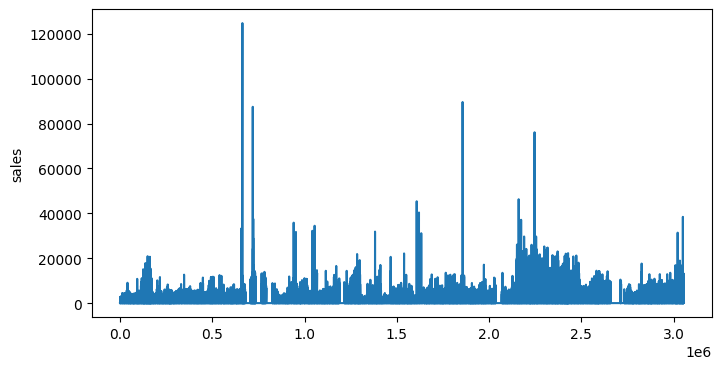

In [104]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df.groupby(df.index)["sales"].sum())

*As we can see, every last day and first day of a year, there was a very contrast trend of buying goods. The sales also gradually increase over time*

Extract day, month and year from the columns date

In [105]:
df["date"] = pd.to_datetime(df["date"])

Set "date" into index of dataframe

In [106]:
df.set_index("date", inplace=True)

In [107]:
df["day"] = df.index.day

In [108]:
df["month"] = df.index.month

In [109]:
df["year"] = df.index.year

<Axes: xlabel='day', ylabel='sales'>

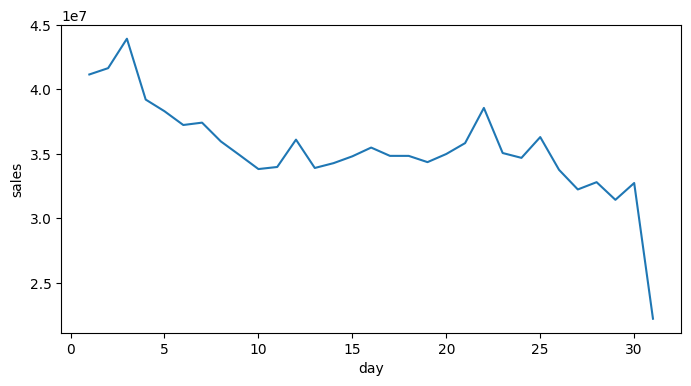

In [110]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df.groupby(df["day"])["sales"].sum())

the way day is the 15th and 30th day of a month, people tend to buy good at beginning of a month , and buy a little more at the second haft of the month

<Axes: xlabel='year', ylabel='sales'>

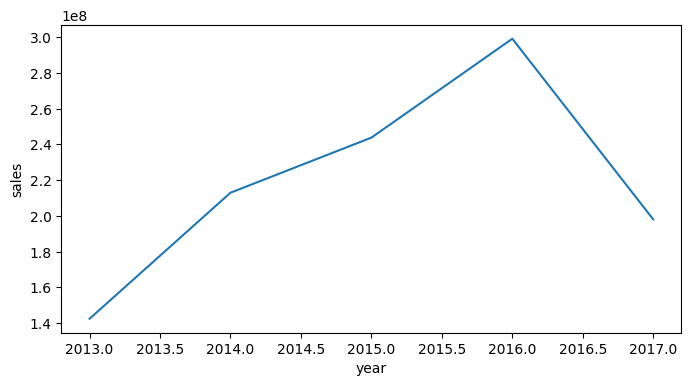

In [111]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df.groupby(df["year"])["sales"].sum())

In 2016 April, there was a disaster which stronggly affect the sales of all store across the country

<Axes: xlabel='month', ylabel='sales'>

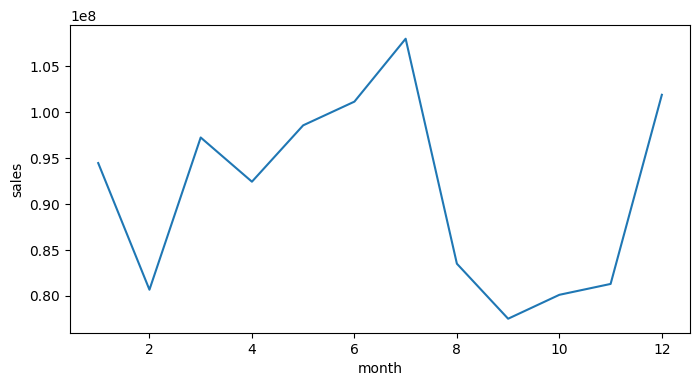

In [112]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df.groupby(df["month"])["sales"].sum())

Peole like to buying good at July and December of every year

<Axes: xlabel='store_nbr', ylabel='sales'>

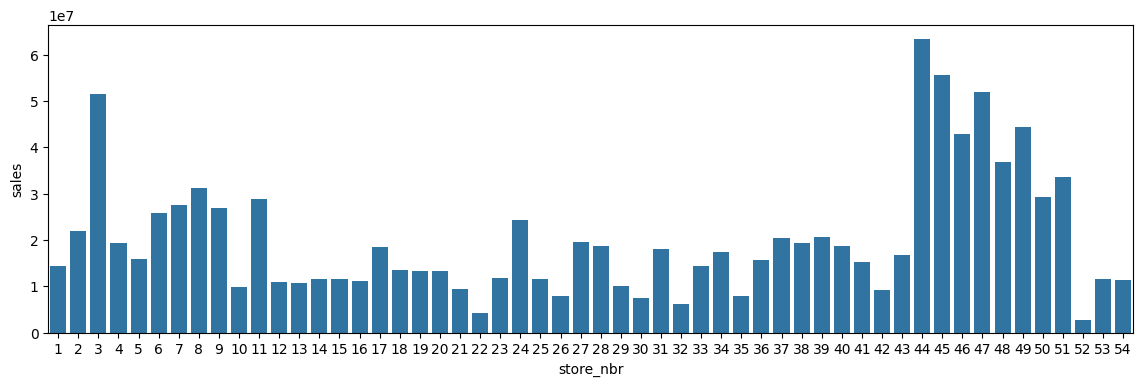

In [113]:
plt.figure(figsize=(14,4))
sns.barplot(data=df.groupby("store_nbr")["sales"].sum())

Some store's sale are bigger than others, but no correlation between sales and store number.

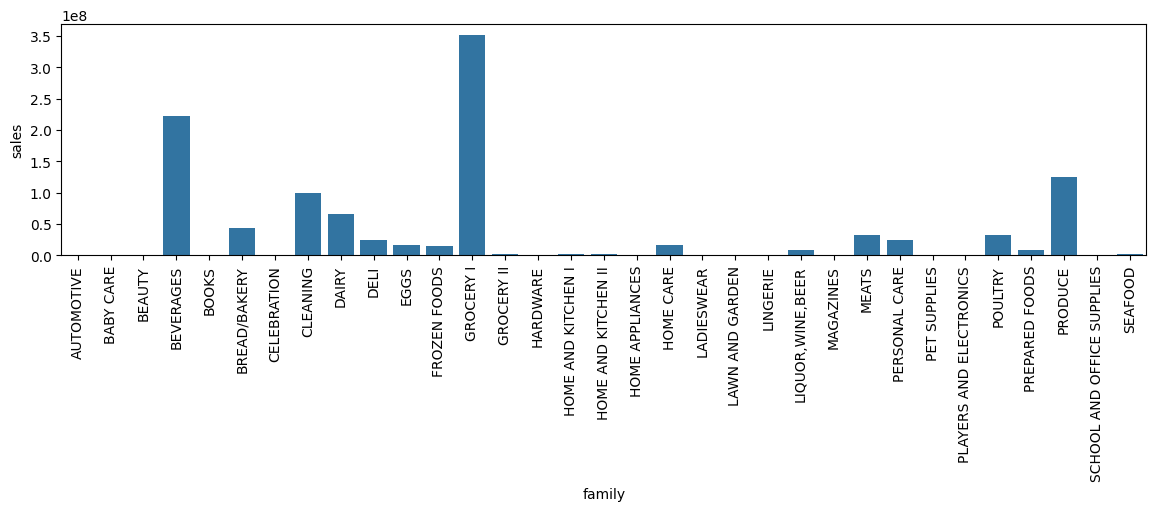

In [114]:
plt.figure(figsize=(14,3))
ax = sns.barplot(data=df.groupby("family")["sales"].sum())
plt.xticks(rotation=90)
plt.show()


*Three biggest category of sale is grocery, beverage and procedure*

#### 3. Preprocessing Data

Filling missing value of oil price

In [115]:
df["oil price"] = df["oil price"].interpolate(method="time")

In [116]:
df["oil price"] = df["oil price"].interpolate(method="nearest", limit_direction="backward")

Columns "type_y" shows that day was a holiday or not, so we will replace the NaN value with "normal" mean a normal day

In [117]:
df["type_y"].replace({np.NaN :"Normal"}, inplace=True)

As the same with "locale" with "unknown" for day that not a holiday

In [118]:
df["locale"].replace({np.NaN :"Unknown"}, inplace=True)

Replace the NaN in "transferred" with "Not" mean that day was not a holiday 

In [119]:
df["transferred"].replace({True:"Yes", False:"No", np.NaN:"Not"}, inplace=True)

In [120]:
df[df["transactions"].isnull()]

,store_nbr,family,sales,onpromotion,type_x,oil price,type_y,locale,transferred,transactions,day,month,year
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,D,93.140,Holiday,National,No,NaN,1,1,2013
2013-01-01,1,BABY CARE,0.0,0,D,93.140,Holiday,National,No,NaN,1,1,2013
2013-01-01,1,BEAUTY,0.0,0,D,93.140,Holiday,National,No,NaN,1,1,2013
2013-01-01,1,BEVERAGES,0.0,0,D,93.140,Holiday,National,No,NaN,1,1,2013
2013-01-01,1,BOOKS,0.0,0,D,93.140,Holiday,National,No,NaN,1,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,9,POULTRY,0.0,0,B,53.055,Holiday,National,Yes,NaN,1,1,2017
2017-01-01,9,PREPARED FOODS,0.0,0,B,53.055,Holiday,National,Yes,NaN,1,1,2017
2017-01-01,9,PRODUCE,0.0,0,B,53.055,Holiday,National,Yes,NaN,1,1,2017


There meny missing value in transactions column, and the transaction is barely affect the buying trend. So we will delete this feature from dataframe

In [121]:
X = df.drop("transactions", axis=1)

After April 2016, there was a disaster, so we will add a columns to mark the date after this disaster

In [122]:
X["disaster"] = False

In [123]:
X["disaster"].loc["2016-04-01":,] = True

/var/folders/y1/6sgwssxd2k1_0nfl4p5yzdb00000gn/T/ipykernel_57769/1284689867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["disaster"].loc["2016-04-01":,] = True


The Wage day is 15 and 30, so we mark this day in the data frame

In [124]:
X["wage_day"] = False

In [125]:
X["wage_day"].loc[(X["day"] == 15) | (X["day"] == 30)] = True

/var/folders/y1/6sgwssxd2k1_0nfl4p5yzdb00000gn/T/ipykernel_57769/1868952936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["wage_day"].loc[(X["day"] == 15) | (X["day"] == 30)] = True


In [126]:
X.head()

,store_nbr,family,sales,onpromotion,type_x,oil price,type_y,locale,transferred,day,month,year,disaster,wage_day
date,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,D,93.14,Holiday,National,No,1,1,2013,False,False
2013-01-01,1,BABY CARE,0.0,0,D,93.14,Holiday,National,No,1,1,2013,False,False
2013-01-01,1,BEAUTY,0.0,0,D,93.14,Holiday,National,No,1,1,2013,False,False
2013-01-01,1,BEVERAGES,0.0,0,D,93.14,Holiday,National,No,1,1,2013,False,False
2013-01-01,1,BOOKS,0.0,0,D,93.14,Holiday,National,No,1,1,2013,False,False


Get dummy for the features columns

In [127]:
X = pd.get_dummies(X, columns=["store_nbr", "family", "type_x", "type_y", "locale", "transferred"])

Prepare for the training and testing part

In [128]:
y = X.pop("sales")

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

In [130]:
X = X.sort_index()
y = y.sort_index()

x_train = X.loc[:"2017-01-01",]
x_test = X.loc["2017-01-01":,]

y_train = y.loc[:"2017-01-01",]
y_test = y.loc["2017-01-01":,]

#### 4. Model Prediction

In [131]:
model = XGBRegressor()

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

r2_score(y_test, y_predict)

0.8350577568568986

In [132]:
y_predict = [0 if x < 0 else x for x in y_predict]

np.sqrt(mean_squared_log_error(y_test,y_predict))                                       

1.553330240456554

In [133]:
mean_absolute_error(y_test, y_predict)

157.63176941965628

As we can see , the R2 score of model tis 0.83 , MSLE is 1.55 and MAE is 157

In [136]:
result = pd.DataFrame({"Prediction": y_predict, "True value": y_test}, )
result.head()

,Prediction,True value
date,,
2017-01-01,0.000000,0.0
2017-01-01,0.000000,0.0
2017-01-01,0.000000,0.0
2017-01-01,0.000000,0.0
2017-01-01,364.295471,0.0


In [135]:
result1.to_csv("result1.csv")